## Example Implementation: Into the Mind of a Locust

Once we have figured out how to implement neurons and networks, we can try to simulate a model of a small part of a Locust's nervous system.

### A Locust Antennal Lobe

To an insect, the sense of smell is its source of essential information about their surroundings. Whether it is getting attracted to a potential mate or finding a source of nutrition, odorants are known to trigger various behaviors in insects. Because of their simpler nervous systems and amazing ability to detect and track odors, insects are used to study olfaction to a great extent. Their most surprising ability is to track odors even in the very noisy natural environments. To study this neurobiology look a the dynamics of the networks involved in the processing of chemosensory information to the insect.

Odorants are detected by receptors in olfactory receptor neurons (ORNs) which undergo a depolarization as a result. The antennal lobe (AL) in the insects' brain is considered to be the primary structure that receives input from ORNs within the antennae. It is the consensus that, since different sets of ORNs are activated by different odors, the coding of the odor identity is combinatorial in nature. Inside the Antennal Lobe, the input from the the ORNs is converted into complex long-lived dynamic transients and complex interacting signals which output to the mushroom body in the insect brain. Moreover, the network in the Locust Antennal Lobe seems to be a random network rather than a genetically encoded network with a particular fixed topology.

The Locust AL has two types of neurons:
1. **Inhibitory Local Interneurons (LN):** They produce GABAergic Synapses ie. GABAa (Fast) and Metabotropic GABA (Slow). They synapse onto other Local Interneurons and to Projection Neurons. A subset of them receive inputs from the ORNs.
2. **Projection Neurons (PN):** They produce Cholinergic Synapses ie. Acetylcholine. They synapse onto local interneurons and also project to the mushroom body outside the AL and act as the output for the AL. A subset of them also receive inputs from the ORNs.


#### A Model of the Locust AL

The model described here is based on Bazhenov 2001b.

<img src="model.png" alt="model.png" width="400"/>

**Total Number of Neurons** = 120  
**Number of PNs** = 90    
**Number of LNs** = 30  

The connectivity is random with different connection probabilities as described below:  

**Probability(PN to PN)** = 0.0  
**Probability(PN to LN)** = 0.5  
**Probability(LN to LN)** = 0.5  
**Probability(LN to PN)** = 0.5  

33% of all neurons receive input from ORNs.

##### Projection Neurons

The projection neurons have an hodgkin huxley dynamics as described below:

$$C_m \frac{dV_{PN}}{dt} = I_{stim} - I_{L} - I_{Na} - I_{K} - I_{A} - I_{KL} - I_{GABA_a} -I_{Ach}$$

It expresses voltage-gated Na$^+$ channels, voltage-gated K$^+$ channels, transient K$^+$ channels, K$^+$ leak channels and general leak channel. The Acetylcholine current is always zero in this model as PNs do not project to PNs.

The PN currents and differential equation for dynamics are described below:
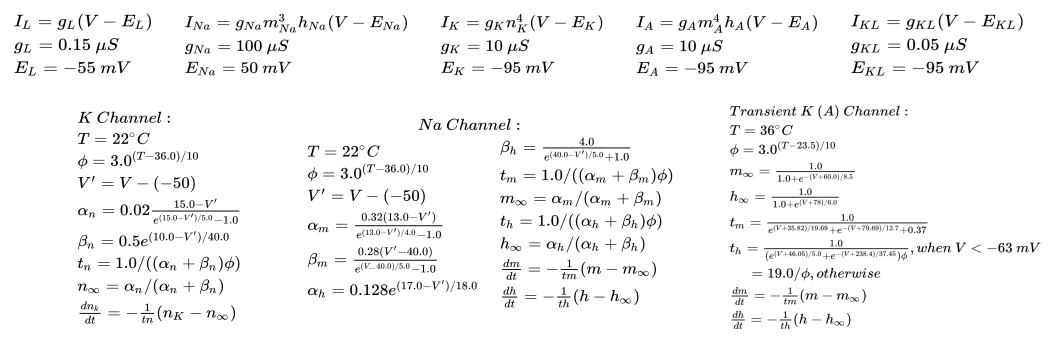

##### Local Interneurons

The Local Interneurons have an dynamics somewhat similar to hodgkin huxley as described below:  

$$C_m \frac{dV_{LN}}{dt} = I_{stim} - I_{L} - I_{Ca} - I_{K} - I_{K(Ca)} - I_{KL} - I_{GABA_a} -I_{Ach}$$

Unlike the Projection neuron, the local interneurons do not have the normal sodium potassium channel action potentials. They expresse voltage-gated Ca$^{2+}$ channels, voltage-gated K$^+$ channels, Calcium dependent K$^+$ channels, K$^+$ leak channels and general leak channel. Here, opposite interactions between K and Ca channels cause longer extended action potentials. The dynamics in intracellular Ca$^{2+}$ causes changes in K(Ca) channel dynamics allowing for adaptive behavior in the neurons.

The LN currents and differential equation for dynamics are described below:
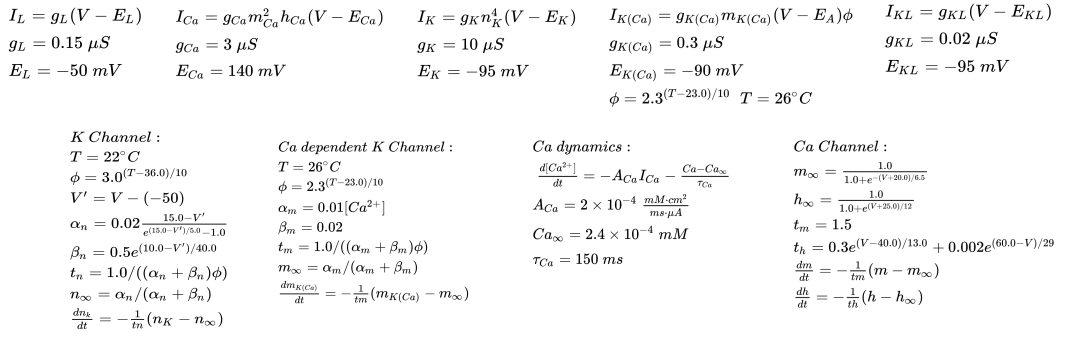

##### Synaptic Dynamics

Finally, the equation of the dynamics of the two types of synapses are given below.

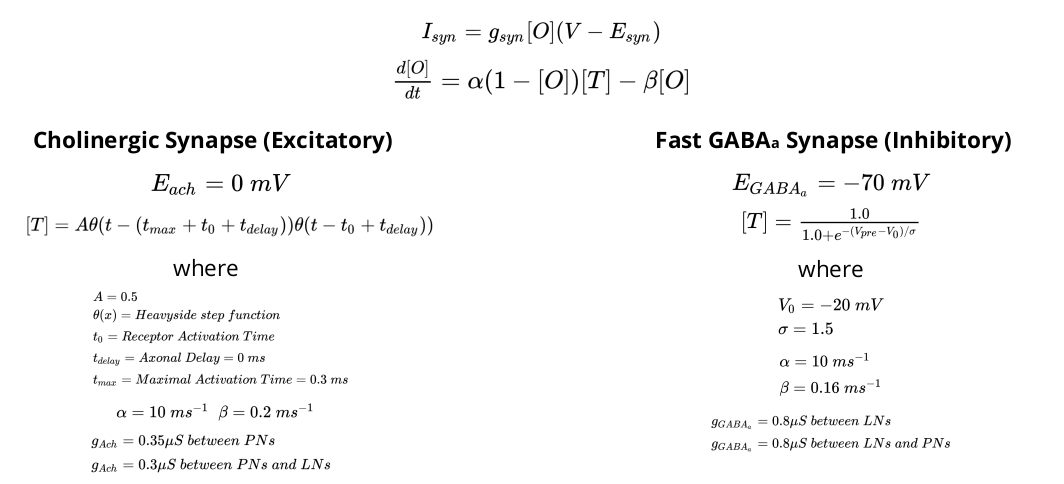

#### Importing Nerveflow

Once the Integrator is saved in tf_integrator.py in the same directory as the Notebook, we can start importing the essentials including the integrator. 

In [1]:
import tensorflow as tf
import numpy as np
import tf_integrator as tf_int
import matplotlib.pyplot as plt
import seaborn as sns

#### Defining Simulation Parameters

Now we can start defining the parameters of the model. First, we define the length of the simulation and the time resolution and create the time array t.

In [2]:
sim_time = 1000 # simulation time (in ms)
sim_res = 0.01 # simulation resolution (in ms)

t = np.arange(0.0, sim_time, sim_res) # time array

Now we start implementing the details of the network. Since there are two different cell types they may have different properties/parameters. As you might remember, our parallelization paradigm allows us to have different values of parameters for different neurons/synapses by having parameter vectors. To make it easy for us to manipulate the information it is best for us to have a convection for splitting parameters into cell types.

Here, we follow the convention that the first 90 values of each common parameter will be for PN cell type and the rest 30 will be for LN cell type. Unique parameters are defined whenever necessary.

In [3]:
# Defining Neuron Counts

n_n = int(120)                 # number of neurons

p_n = int(90)                  # number of PNs
l_n = int(30)                  # number of LNs

C_m  = [1.0]*n_n                     # Capacitance

# Defining Common Current Parameters #

g_K  = [10.0]*n_n                    # K conductance
g_L  = [0.15]*n_n                    # Leak conductance
g_KL  = [0.05]*p_n + [0.02]*l_n      # K leak conductance (first 90 for PNs and next 30 for LNs)

E_K  = [-95.0]*n_n                   # K Potential
E_L  = [-55.0]*p_n + [-50.0]*l_n     # Leak Potential (first 90 for PNs and next 30 for LNs)
E_KL  = [-95.0]*n_n                  # K Leak Potential

# Defining Cell Type Specific Current Parameters #

## PNs

g_Na = [100.0]*p_n                   # Na conductance
g_A  = [10.0]*p_n                    # Transient K conductance

E_Na = [50.0]*p_n                    # Na Potential
E_A  = [-95.0]*p_n                   # Transient K Potential

## LNs

g_Ca = [3.0]*l_n                     # Ca conductance
g_KCa = [0.3]*l_n                    # Ca dependent K conductance

E_Ca = [140.0]*l_n                   # Ca Potential
E_KCa = [-90]*l_n                    # Ca dependent K Potential

A_Ca = [2*(10**(-4))]*l_n            # Ca outflow rate
Ca0 = [2.4*(10**(-4))]*l_n           # Equilibrium Calcium Concentration
t_Ca = [150]*l_n                     # Ca recovery time constant

## Defining Firing Thresholds ##

F_b = [0.0]*n_n                      # Fire threshold

## Defining Acetylcholine Synapse Connectivity ##

ach_mat = np.zeros((n_n,n_n))                                 # Ach Synapse Connectivity Matrix
ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n)) # 50% probability of PN -> LN
np.fill_diagonal(ach_mat,0.)                                  # Remove all self connection

## Defining Acetylcholine Synapse Parameters ##

n_syn_ach = int(np.sum(ach_mat))     # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_syn_ach           # Alpha for Ach Synapse
bet_ach = [0.2]*n_syn_ach            # Beta for Ach Synapse
t_max = 0.3                          # Maximum Time for Synapse
t_delay = 0                          # Axonal Transmission Delay
A = [0.5]*n_n                        # Synaptic Response Strength
g_ach = [0.35]*p_n+[0.3]*l_n         # Ach Conductance
E_ach = [0.0]*n_n                    # Ach Potential

## Defining GABAa Synapse Connectivity ##

fgaba_mat = np.zeros((n_n,n_n))                              # GABAa Synapse Connectivity Matrix
fgaba_mat[:,p_n:] = np.random.choice([0.,1.],size=(n_n,l_n)) # 50% probability of LN -> LN/PN
np.fill_diagonal(fgaba_mat,0.)                               # No self connection

## Defining GABAa Synapse Parameters ##
    
n_syn_fgaba = int(np.sum(fgaba_mat)) # Number of GABAa (fGABA) Synapses
alp_fgaba = [10.0]*n_syn_fgaba       # Alpha for fGABA Synapse
bet_fgaba = [0.16]*n_syn_fgaba       # Beta for fGABA Synapse
V0 = [-20.0]*n_n                     # Decay Potential
sigma = [1.5]*n_n                    # Decay Time Constant
g_fgaba = [0.8]*p_n+[0.8]*l_n        # fGABA Conductance
E_fgaba = [-70.0]*n_n                # fGABA Potential

#### Visualizing the Connectivity

Now that we have a connectivity matrix, we can visualize the connectivity as a heatmap. For this, we combine the two synapse connectivity matrix to get a single matrix that has +1 for excitatory connection and -1 for inhibitory connections. Then we use seaborn library to get a clean heatmap.

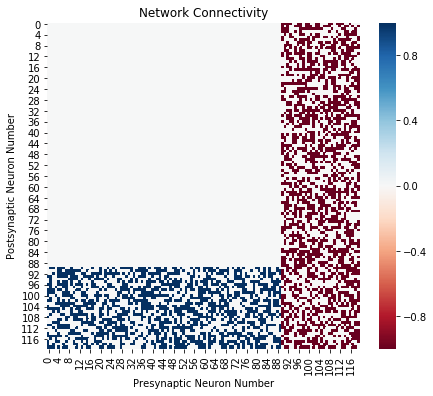

In [4]:
plt.figure(figsize=(7,6))
sns.heatmap(ach_mat-fgaba_mat, cmap="RdBu")
plt.xlabel("Presynaptic Neuron Number")
plt.ylabel("Postsynaptic Neuron Number")
plt.title("Network Connectivity")
plt.show()

#### Defining the functions to evaluate dynamics in gating variables

Now, we define all the functions that will evaluate the equilibium value and time constants of gating variable for different channels.

In [5]:
def K_prop(V):
    
    T = 22
    
    phi = 3.0**((T-36.0)/10)
    
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    
    phi = 3.0**((T-36)/10)
    
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h


def A_prop(V):
    T = 36
    
    phi = 3.0**((T-23.5)/10)
    
    m_0 = 1/(1+tf.exp(-(V+60.0)/8.5))
    h_0 = 1/(1+tf.exp((V+78.0)/6.0))
    
    tau_m = 1/(tf.exp((V+35.82)/19.69) + tf.exp(-(V+79.69)/12.7) + 0.37) / phi
    
    t1 = 1/(tf.exp((V+46.05)/5.0) + tf.exp(-(V+238.4)/37.45)) / phi
    t2 = (19.0/phi) * tf.ones(tf.shape(V),dtype=V.dtype)
    tau_h = tf.where(tf.less(V,-63.0),t1,t2)
    
    return m_0, tau_m, h_0, tau_h


def Ca_prop(V):
    
    m_0 = 1/(1+tf.exp(-(V+20.0)/6.5))
    h_0 = 1/(1+tf.exp((V+25.0)/12))
    
    tau_m = 1.5
    tau_h = 0.3*tf.exp((V-40.0)/13.0) + 0.002*tf.exp((60.0-V)/29)
    
    return m_0, tau_m, h_0, tau_h

def KCa_prop(Ca):
    T = 26
    
    phi = 2.3**((T-23.0)/10)
    
    alpha = 0.01*Ca
    beta = 0.02
    
    tau = 1/((alpha+beta)*phi)
    
    return alpha*tau*phi, tau

#### Defining Channel Currents, Synaptic Potentials, and Input Currents (Injection Current)

Just like the normal hodgkin-huxley network, we define the different functions that evaluate the different neuronal currents.

In [6]:
# NEURONAL CURRENTS

# Common Currents #

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

def I_KL(V):
    return g_KL * (V - E_KL)

# PN Currents #

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_A(V, m, h):
    return g_A * m**4 * h * (V - E_A)

# LN Currents #

def I_Ca(V, m, h):
    return g_Ca * m**2 * h * (V - E_Ca)

def I_KCa(V, m):
    T = 26
    phi = 2.3**((T-23.0)/10)
    return g_KCa * m * phi * (V - E_KCa)

# SYNAPTIC CURRENTS

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1)

def I_fgaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),fgaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_fgaba))*g_fgaba),1)

# INPUT CURRENTS

def I_inj_t(t):
    return tf.constant(current_input.T,dtype=tf.float64)[tf.to_int32(t*100)]

#### Putting Together the Dynamics

The construction of the function that evaluates the dynamical equations is similar to the normal HH Model but we have a small difference. That is, not all neurons share the same dynamical equations, they have some common terms and some terms that are unique. The procedure we deal with this is briefly explained below.

$$\frac{d\vec{X_A}}{dt} = f(\vec{X_{A_\alpha}},\vec{X_{A_\beta}}...)+g_A(\vec{X_{A_\gamma}}...)\ \ \ \ \ \ \frac{d\vec{X_B}}{dt} = f(\vec{X_{B_\alpha}},\vec{X_{B_\beta}}...)+g_B(\vec{X_{B_\gamma}}...)$$
$$To\ evaluate\ \frac{d\vec{X}}{dt}\ where\ \vec{X}=[\vec{X_A},\vec{X_B}], Find:$$

$$\Big(\frac{dX_A}{dt}\Big)_{unique}=g_A(\vec{X_{A_\gamma}}..)\ \ \ \ \ \ \ \ \ \ \ \ \ \Big(\frac{dX_B}{dt}\Big)_{unique}=g_B(\vec{X_{B_\gamma}}..)$$
  
$$\Big(\frac{dX}{dt}\Big)_{unique}=\Big[\Big(\frac{dX_A}{dt}\Big)_{unique},\Big(\frac{dX_B}{dt}\Big)_{unique}\Big]$$


$$\frac{dX}{dt}=\Big(\frac{dX}{dt}\Big)_{unique}+f(\vec{X_{\alpha}},\vec{X_{\beta}}...)$$

This way, we can minimize the number of computations required for the simulation and all the computations are highly parallelizeable by TensorFlow. As for the vector we follow the convention given below:

* Voltage(PN)[90]
* Voltage(LN)[30]
* K-gating(ALL)[120]
* Na-activation-gating(PN)[90]
* Na-inactivation-gating(PN)[90]
* Transient-K-activation-gating(PN)[90]
* Transient-K-inactivation-gating(PN)[90]
* Ca-activation-gating(LN)[30]
* Ca-inactivation-gating(LN)[30]
* K(Ca)-gating(LN)[30]
* Ca-concentration(LN)[30]
* Acetylcholine Open Fraction[n_syn_ach]
* GABAa Open Fraction[n_syn_fgaba]
* Fire-times[120]

In [7]:
def dXdt(X, t): # X is the state vector
    
    V_p   = X[0   : p_n] # Voltage(PN)
    V_l   = X[p_n : n_n] # Voltage(LN)
    
    n_K   = X[n_n : 2*n_n] # K-gating(ALL)
    
    m_Na  = X[2*n_n : 2*n_n + p_n] # Na-activation-gating(PN)
    h_Na  = X[2*n_n + p_n : 2*n_n + 2*p_n] # Na-inactivation-gating(PN)

    m_A   = X[2*n_n + 2*p_n : 2*n_n + 3*p_n] # Transient-K-activation-gating(PN)
    h_A   = X[2*n_n + 3*p_n : 2*n_n + 4*p_n] # Transient-K-inactivation-gating(PN)
    
    m_Ca  = X[2*n_n + 4*p_n : 2*n_n + 4*p_n + l_n] # Ca-activation-gating(LN)
    h_Ca  = X[2*n_n + 4*p_n + l_n: 2*n_n + 4*p_n + 2*l_n] # Ca-inactivation-gating(LN)
    
    m_KCa = X[2*n_n + 4*p_n + 2*l_n : 2*n_n + 4*p_n + 3*l_n] # K(Ca)-gating(LN)
    Ca    = X[2*n_n + 4*p_n + 3*l_n: 2*n_n + 4*p_n + 4*l_n] # Ca-concentration(LN)

    o_ach = X[6*n_n : 6*n_n + n_syn_ach] # Acetylcholine Open Fraction
    o_fgaba = X[6*n_n + n_syn_ach : 6*n_n + n_syn_ach + n_syn_fgaba] # GABAa Open Fraction
    
    fire_t = X[-n_n:] # Fire-times
    
    V = X[:n_n] # Overall Voltage (PN + LN)
    
    
    # Evaluate Differentials for Gating variables and Ca concentration
    
    n0,tn = K_prop(V)
    
    dn_k = - (1.0/tn)*(n_K-n0)
    
    m0,tm,h0,th = Na_prop(V_p)
    
    dm_Na = - (1.0/tm)*(m_Na-m0)
    dh_Na = - (1.0/th)*(h_Na-h0)
    
    m0,tm,h0,th = A_prop(V_p)
    
    dm_A = - (1.0/tm)*(m_A-m0)
    dh_A = - (1.0/th)*(h_A-h0)
    
    m0,tm,h0,th = Ca_prop(V_l)
    
    dm_Ca = - (1.0/tm)*(m_Ca-m0)
    dh_Ca = - (1.0/th)*(h_Ca-h0)
    
    m0,tm = KCa_prop(Ca)
    
    dm_KCa = - (1.0/tm)*(m_KCa-m0)
    
    dCa = - A_Ca*I_Ca(V_l,m_Ca,h_Ca) - (Ca - Ca0)/t_Ca
    
    # Evaluate differential for Voltage
    
    # The dynamical equation for voltage has both unique and common parts.
    # Thus, as discussed above, we first evaluate the unique parts of Cm*dV/dT for LNs and PNs.
    
    CmdV_p = - I_Na(V_p, m_Na, h_Na) - I_A(V_p, m_A, h_A)
    CmdV_l = - I_Ca(V_l, m_Ca, h_Ca) - I_KCa(V_l, m_KCa)
    
    # Once we have that, we merge the two into a single 120-vector.
    
    CmdV = tf.concat([CmdV_p,CmdV_l],0)
    
    # Finally we add the common currents and divide by Cm to get dV/dt.
    
    dV = (I_inj_t(t) + CmdV - I_K(V, n_K) - I_L(V) - I_KL(V) - I_ach(o_ach,V) - I_fgaba(o_fgaba,V)) / C_m
    
    # Evaluate dynamics in synapses
    
    A_ = tf.constant(A,dtype=tf.float64)
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,tf.zeros(tf.shape(A_),dtype=A_.dtype))
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    T_fgaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_fgaba = tf.multiply(tf.constant(fgaba_mat,dtype=tf.float64),T_fgaba)
    T_fgaba = tf.boolean_mask(tf.reshape(T_fgaba,(-1,)),fgaba_mat.reshape(-1) == 1)
    do_fgabadt = alp_fgaba*(1.0-o_fgaba)*T_fgaba - bet_fgaba*o_fgaba
    
    # Set change in fire-times as zero
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype)

    # Combine to a single vector
    
    out = tf.concat([dV,         dn_k,
                     dm_Na,      dh_Na,
                     dm_A,       dh_A,
                     dm_Ca,      dh_Ca,
                     dm_KCa,     
                     dCa,        do_achdt,
                     do_fgabadt, dfdt   ],0)
    return out

#### Creating the Current Input and Run the Simulation

We will run an 1000 ms simulation where we will give input to randomly chosen 33% of the neurons. The input will be an saturating increase to 10 from 100 ms to 600 ms and an exponetial decrease to 0 after 600 ms. 

In [8]:
current_input = np.zeros((n_n,t.shape[0]))

# Create the input shape

y = np.where(t<600,(1-np.exp(-(t-100)/75)),0.9996*np.exp(-(t-600)/150))
y = np.where(t<100,np.zeros(t.shape),y)

# Randomly choose 33% indices from 120

p_input = 0.33
input_neurons = np.random.choice(np.array(range(n_n)),int(p_input*n_n),replace=False)

# Assign input shape to chosen indices

current_input[input_neurons,:]= 10*y

#### Create the initial state vector and add some jitter to break symmetry

We create the initial state vector, initializing voltage to $-70\ mV$, gating variables and open fractions to $0.0$, and calcium concentration to $2.4\times10^{-4}$ and add 1% gaussian noise to the data.

In [9]:
state_vector =  [-70]* n_n + [0.0]* (n_n + 4*p_n + 3*l_n) + [2.4*(10**(-4))]*l_n + [0]*(n_syn_ach+n_syn_fgaba) + [-(sim_time+1)]*n_n
state_vector = np.array(state_vector)
state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)
init_state = tf.constant(state_vector, dtype=tf.float64)

#### Running the simulation and Interpreting the Output

In [10]:
state = tf_int.odeint(dXdt, init_state, t, n_n, F_b)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state = sess.run(state)
    sess.close()

To visualize the data, we plot the voltage traces of the PNs (Neurons 0 to 89) and LNs (Neurons 90 to 119) as a Voltage vs Time heatmap, peaks in the data are the action potentials.

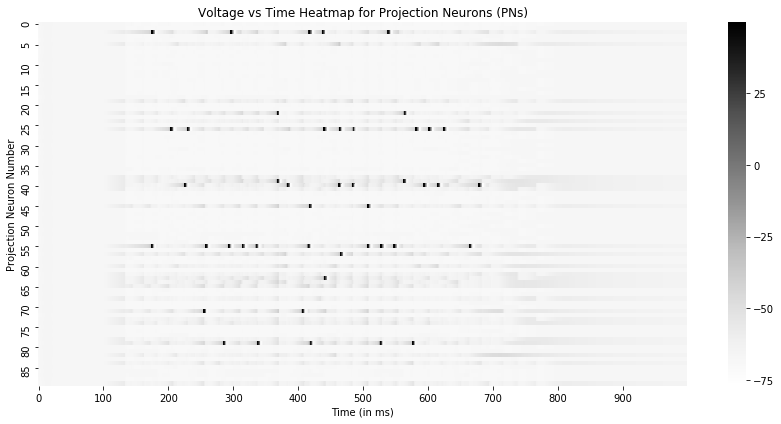

In [11]:
plt.figure(figsize=(12,6))
    
sns.heatmap(state[::100,:90].T,xticklabels=100,yticklabels=5,cmap='Greys')

plt.xlabel("Time (in ms)")
plt.ylabel("Projection Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")

plt.tight_layout()
plt.show()

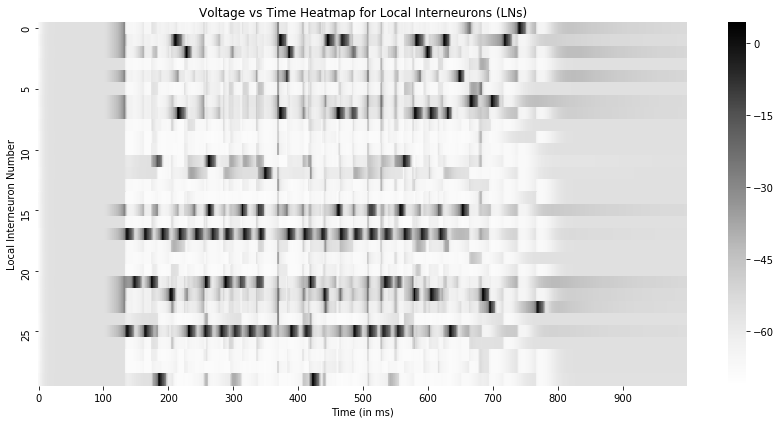

In [12]:
plt.figure(figsize=(12,6))
    
sns.heatmap(state[::100,90:120].T,xticklabels=100,yticklabels=5,cmap='Greys')

plt.xlabel("Time (in ms)")
plt.ylabel("Local Interneuron Number")
plt.title("Voltage vs Time Heatmap for Local Interneurons (LNs)")

plt.tight_layout()
plt.show()

Thus, We are capable of making models of complex realistic networks of neurons in the brains of living organisms. As an **Exercise** implement the batch and caller-runner system for this example as taught in day 5. Use this to implement a simulation of successive box input to 1/3rd of the neurons for a period of 2 seconds. Also try introducing variability to the parameters of the neurons.